# Space- and time-dependent external source

### Authors: Esra Ilke Albar, Franco Bonafé, Carlos Bustamante, Heiko Appel

Within the new multisystem framework, we can use the `ExternalSource` feature for simulations with space dependent laser pulses. It gives us the possibility to assign a laser that is both a function of space and time. The purpose of this tutorial is to learn how to convert the time-dependent external fields input variables, defined in the "legacy-mode" of Octopus via `TDExternalFields`, to space- and time-dependent fields using `ExternalSource`.

The reference calculation using `ExternalSource` is the one covered in the [full minimal coupling tutorial](./tutorial_full_minimal.ipynb). In that input file, we have set an external field that can be written as:

$ A(\vec{r}, t) = A_0 \exp (i(\vec{k}\cdot\vec{r} - \omega t + \phi)) \exp(\frac{−(\vec{k}\cdot (\vec{r} - \vec{r}_0)/|\vec{k}|)^2}{2 \sigma^2})$

where $k=\omega/c$ using the following block in the input file:

```
AnalyticalExternalSource = yes
%ExternalSource.MaxwellIncidentWaves
 plane_wave_mx_function | vector_potential | -ampl*c/omega | 0 | 0 | "plane_waves_function" | phase_vec
%
%MaxwellFunctions
  "plane_waves_function" | mxf_gaussian_wave | 0 | omega/c | 0 | 0 | p_s | 0 | pw
%
```

Now we will run the equivalent simulation with TDExternalFields to compare. We create new folders for the required ground state calculation and one for the time propagation called TD_EXT_FIELDS_DIR

In [57]:
import os

from postopus import Run


In [52]:
if not os.path.exists('GS_DIR'):
    os.mkdir('GS_DIR')

In [53]:
%%writefile GS_DIR/benzene.xyz
12
units: A
      C                    0.000000    1.364239    0.000000
      C                    1.191347    0.685530    0.000000
      C                    1.191347   -0.685530    0.000000
      C                    0.000000   -1.364239    0.000000
      C                   -1.191347   -0.685530    0.000000
      C                   -1.191347    0.685530    0.000000
      H                    0.000000    2.441134    0.000000
      H                    2.124739    1.238817    0.000000
      H                    2.124739   -1.238817    0.000000
      H                    0.000000   -2.441134    0.000000
      H                   -2.124739   -1.238817    0.000000
      H                   -2.124739    1.238817    0.000000

Writing GS_DIR/benzene.xyz


In [54]:
%%writefile GS_DIR/inp

CalculationMode = gs
ExperimentalFeatures = yes
FromScratch = yes
Dimensions = 3

XYZCoordinates = "benzene.xyz"
UnitsXYZFiles = angstrom_units
AllElectronType = full_delta

ExtraStates = 1

BoxShape = parallelepiped
Spacing = 0.1*angstrom
%Lsize
 3.5*angstrom | 3.5*angstrom | 1.5*angstrom
%

Writing GS_DIR/inp


In [55]:
%%bash
cd GS_DIR
export OMP_NUM_THREADS=1
mpirun -np 6 octopus >& out.log

and we run the following input files for time dependent calculation:

In [81]:
if not os.path.exists('TD_EXT_FIELDS_DIR'):
    os.mkdir('TD_EXT_FIELDS_DIR')

In [82]:
%%writefile TD_EXT_FIELDS_DIR/benzene.xyz

  12
 units: A
      C                    0.000000    1.364239    0.000000
      C                    1.191347    0.685530    0.000000
      C                    1.191347   -0.685530    0.000000
      C                    0.000000   -1.364239    0.000000
      C                   -1.191347   -0.685530    0.000000
      C                   -1.191347    0.685530    0.000000
      H                    0.000000    2.441134    0.000000
      H                    2.124739    1.238817    0.000000
      H                    2.124739   -1.238817    0.000000
      H                    0.000000   -2.441134    0.000000
      H                   -2.124739   -1.238817    0.000000
      H                   -2.124739    1.238817    0.000000

Writing TD_EXT_FIELDS_DIR/benzene.xyz


In [91]:
%%writefile TD_EXT_FIELDS_DIR/inp

CalculationMode = td
ExperimentalFeatures = yes
FromScratch = yes
RestartWallTimePeriod = 10.01
ParStates = no

%Systems
 "benzene" | electronic
%

XYZCoordinates = "benzene.xyz"
UnitsXYZFiles = angstrom_units
AllElectronType = full_delta

BoxShape = parallelepiped
Spacing = 0.1*angstrom
%Lsize
 3.5*angstrom | 3.5*angstrom | 1.5*angstrom
%

%TDOutput
 multipoles
%

omega = 270*ev
period = 0.015*fs
ampl = 0.0001
tau0 = 1*period # sigma
t0 = tau0*3
phase_vec = -pi/2
phase0 = 0.51

TDSystemPropagator = prop_aetrs
benzene.TDTimeStep = 0.008
TDPropagationTime = 7*period

%TDExternalFields
 vector_potential | -1 | 0 | 0 | omega | "gauss" | "phase"
%

%TDFunctions
 "gauss" | tdf_gaussian | ampl*c/omega | tau0 | t0
 "phase" | tdf_cw | phase_vec + phase0
%

Overwriting TD_EXT_FIELDS_DIR/inp


Running Octopus:

In [92]:
%%bash
cp -r GS_DIR TD_EXT_FIELDS_DIR/benzene
cd TD_EXT_FIELDS_DIR
export OMP_NUM_THREADS=1
mpirun -np 6 octopus > out.log


** Warning:
**   Multi-system framework is under development.
**   It might not work or produce wrong results.



As can be seen, we are considering the effect of an external laser defined with the usual time-dependent function:

$ A(t) = A_0 \exp (-i (\omega t + \phi)) \exp(−\frac{(t−t_0)^2)}{2 \tau_0^2}) $

which should be equal to the previous expression for $A(\vec{r},t)$ for $\vec{r} = 0$ (or $\vec{r}$ equal to the center of mass/center of charge of the system, depending on the definition of "center" that is being used). Here, we do not need to set any level of light-matter coupling, as the level of coupling is dipole.

Let us plot and look the multipole response of the molecule for two cases now. You can use [Postopus](https://gitlab.com/octopus-code/postopus) to probe the response to two lasers:

As also done in Full Minimal Coupling tutorials, we can perform the space dependent calculations and compare with the only time dependent laser.

In [85]:
if not os.path.exists('EXT_SOURCE_DIPOLE_DIR'):
    os.mkdir('EXT_SOURCE_DIPOLE_DIR')

In [86]:
%%writefile EXT_SOURCE_DIPOLE_DIR/benzene.xyz
12
units: A
      C                    0.000000    1.364239    0.000000
      C                    1.191347    0.685530    0.000000
      C                    1.191347   -0.685530    0.000000
      C                    0.000000   -1.364239    0.000000
      C                   -1.191347   -0.685530    0.000000
      C                   -1.191347    0.685530    0.000000
      H                    0.000000    2.441134    0.000000
      H                    2.124739    1.238817    0.000000
      H                    2.124739   -1.238817    0.000000
      H                    0.000000   -2.441134    0.000000
      H                   -2.124739   -1.238817    0.000000
      H                   -2.124739    1.238817    0.000000

Writing EXT_SOURCE_DIPOLE_DIR/benzene.xyz


In [87]:
%%writefile EXT_SOURCE_DIPOLE_DIR/inp

CalculationMode = td
ExperimentalFeatures = yes
FromScratch = yes
RestartWallTimePeriod = 10.01
ParStates = no

%Systems
 "benzene" | electronic
%

XYZCoordinates = "benzene.xyz"
UnitsXYZFiles = angstrom_units
AllElectronType = full_delta

BoxShape = parallelepiped
benzene.Spacing = 0.1*angstrom
%benzene.Lsize
 3.5*angstrom | 3.5*angstrom | 1.5*angstrom
%

%TDOutput
 maxwell_field
 multipoles
%
%Output
 density | plane_z
%
OutputInterval = 20

omega = 270*ev
period = 0.015*fs
ampl = 0.0001
tau0 = 1*period # sigma
t0 = tau0*3
p_s = - t0*c
pw  = tau0*c
phase_vec = -pi/2

TDSystemPropagator = prop_aetrs
benzene.TDTimeStep = 0.008
TDPropagationTime = 7*period

MaxwellCouplingMode = velocity_gauge_dipole
AnalyticalExternalSource = yes
%ExternalSource.MaxwellIncidentWaves
 plane_wave_mx_function | vector_potential | -ampl*c/omega | 0 | 0 | "plane_waves_function" | phase_vec
%
%MaxwellFunctions
  "plane_waves_function" | mxf_gaussian_wave | 0 | omega/c | 0 | 0 | p_s | 0 | pw
%

Writing EXT_SOURCE_DIPOLE_DIR/inp


In [88]:
%%bash
cp -r GS_DIR EXT_SOURCE_DIPOLE_DIR/benzene
cd EXT_SOURCE_DIPOLE_DIR
export OMP_NUM_THREADS=1
mpirun -np 6 octopus > out.log


** Warning:
**   Plane-wave is currently always 3D and non-periodic.


** Warning:
**   Multi-system framework is under development.
**   It might not work or produce wrong results.


** Warning:
** In namespace benzene:
**   TDOutput = maxwell_field is under development.
**   It might not work or produce wrong results.



/usr/local/lib/python3.11/dist-packages/postopus/files/pandas_text.py:186: UserWarning: We do not know this type of static/td.general file (EXT_SOURCE_DIPOLE_DIR/benzene/td.general/maxwell_dipole_field). It is probably easily possible to optimize the reading of it. So, please contact us!
  warnings.warn(


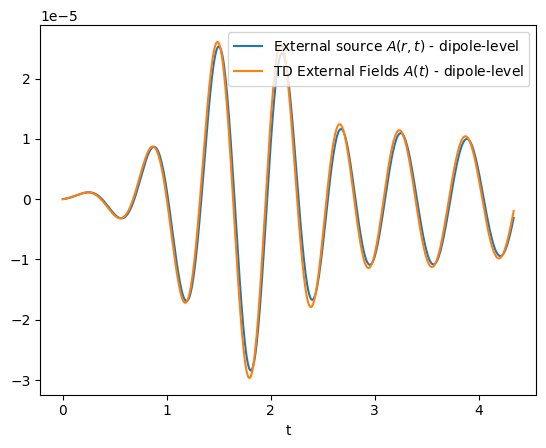

In [89]:
run_ext_source = Run("EXT_SOURCE_DIPOLE_DIR")
run_td_ext_fields = Run("TD_EXT_FIELDS_DIR")

ax = run_ext_source.benzene.td.multipoles.plot(x="t", y= "<x>(1)", label ="External source $A(r,t)$ - dipole-level")
run_td_ext_fields.benzene.td.multipoles.plot(x="t", y= "<x>(1)", label = "TD External Fields $A(t)$ - dipole-level", ax=ax);

As we can see from the plot, time dependent laser and space dependent laser can be engineered to give the same dipole response at the position of the molecule. However, space dependence can be crucial in cases where a beyond dipole response is expected, as we will see below.

_Exercise_:
1. It is visible that the dipole signals are not exactly equal. This difference is already present in the external fields. Plot the external fields from both calculations, comparing the outputs in `EXT_SOURCE_DIPOLE_DIR/benzene/td.general/maxwell_dipole_field` and `TD_EXT_FIELDS_DIR/benzene/td.general/laser`. Keep in mind that the `maxwell_dipole_field` output is already rescaled by $1/c$ ($c= 137.03599$ is the speed of light in atomic units), so you have to scale it back by a factor of $c$. What could be the reason between the difference of both fields? What are the parameters that makes two fields similar/different? _Hint: think about how one can define a "space-independent" field, if all fields are space-dependent_.

_Questions_:

1. Which external field/conditions would yield large effects when the space dependence is included? 
2. Do you think quadrupole effects can be described with a time dependent source?
3. Which calculation runs faster: the one using `TDExternalFields` or `ExternalSource`? What could be the reason for the different timings?

In [90]:
#Help for the comparison of the external fields:

import matplotlib.pyplot as plt
%matplotlib inline

efield_extsource = run_ext_source.benzene.td.maxwell_dipole_field
efield_legacy = run_td_ext_fields.benzene.td.laser

plt.plot(efield_extsource.to_numpy()[:,1],efield_extsource.to_numpy()[:,2]*(137))
plt.plot(efield_legacy.to_numpy()[:,0],efield_legacy.to_numpy()[:,1])